In [2]:
#import library
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

In [39]:
dataset_path = "Training/datarambutan"
print(os.listdir(dataset_path))

['matangbusuk', 'matangsegar', 'mentahbusuk', 'mentahsegar']


In [47]:
# dataset path directory
dataset_path = "Training/datarambutan"

# Path for  directory for  training and validation data
base_output_path = "Training/split_data"
training_path = os.path.join(base_output_path, "train_data")
validation_path = os.path.join(base_output_path, "val_data")

# List all class in dataset aksara Wianjana
classes = os.listdir(dataset_path)

# Looping through every class
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)

    # get list file  in each class
    files = os.listdir(class_path)

    # split dataset to training and  validation data, training data(80%) and validation(20%)
    train_files, validation_files = train_test_split(files, test_size=0.2, random_state=42)

    # making new directory
    os.makedirs(os.path.join(training_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_path, class_name), exist_ok=True)
    
    # move file to training data directory
    for file in train_files:
        source_path = os.path.join(class_path, file)
        destination_path = os.path.join(training_path, class_name, file)
        shutil.copyfile(source_path, destination_path)

    # move file to  validation data directory
    for file in validation_files:
        source_path = os.path.join(class_path, file)
        destination_path = os.path.join(validation_path, class_name, file)
        shutil.copyfile(source_path, destination_path)

print("Split  Dataset  to 70% for training and 30% for validation successfully.")

Split  Dataset  to 70% for training and 30% for validation successfully.


In [14]:
#Check data distribution
def count_files_in_directory(directory):
    return len(os.listdir(directory))

def check_data_distribution(training_dir, validation_dir):
    classes_training = os.listdir(training_dir)
    classes_validation = os.listdir(validation_dir)

    print("Data distribution in training directory:")
    for class_name in classes_training:
        class_path = os.path.join(training_dir, class_name)
        num_files = count_files_in_directory(class_path)
        print(f"{class_name}: {num_files} files")

    print("\nData distribution in validation directory:")
    for class_name in classes_validation:
        class_path = os.path.join(validation_dir, class_name)
        num_files = count_files_in_directory(class_path)
        print(f"{class_name}: {num_files} files")

# Replace with the appropriate path
TRAINING_DIR = "Training/split_data/train_data"
VALIDATION_DIR = "Training/split_data/val_data"

check_data_distribution(TRAINING_DIR, VALIDATION_DIR)

Data distribution in training directory:
matangbusuk: 86 files
matangsegar: 86 files
mentahbusuk: 86 files
mentahsegar: 86 files

Data distribution in validation directory:
matangbusuk: 22 files
matangsegar: 22 files
mentahbusuk: 22 files
mentahsegar: 22 files


In [15]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    TRAINING_DIR = "Training/split_data/train_data"
    VALIDATION_DIR = "Training/split_data/val_data"

    # NORMALIZE
    training_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        )

    validation_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0
    )

    train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                           target_size=(256, 256),
                                                           batch_size=32,
                                                           class_mode='categorical',
                                                           shuffle = True)
    validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                  target_size=(256, 256),
                                                                  batch_size=32,
                                                                  class_mode='categorical',
                                                                  shuffle = True)
    return train_generator, validation_generator

In [16]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 344 images belonging to 4 classes.
Found 88 images belonging to 4 classes.


In [550]:
sequential_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256,3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4, activation="softmax"),
    ])
sequential_model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_92 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_90 (Conv2D)          (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_93 (MaxPooli  (None, 62, 62, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_91 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_94 (MaxPooli  (None, 30, 30, 32)      

In [551]:
from tensorflow.keras.optimizers import Adam
sequential_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= .95 and logs.get('accuracy') >= .92):
            self.model.stop_training = True
            print('\nAccuracy Complete')
callbacks = myCallbacks()
sequential_history = sequential_model.fit(train_generator, epochs=50,validation_data=validation_generator,verbose=1,
                    callbacks=[callbacks])

Epoch 1/50
11/11 [==============================] - 10s 762ms/step - loss: 1.7786 - accuracy: 0.3227 - val_loss: 1.2101 - val_accuracy: 0.5000
Epoch 2/50
11/11 [==============================] - 8s 728ms/step - loss: 1.1465 - accuracy: 0.4971 - val_loss: 0.8370 - val_accuracy: 0.7045
Epoch 3/50
11/11 [==============================] - 8s 729ms/step - loss: 0.9019 - accuracy: 0.5988 - val_loss: 0.6377 - val_accuracy: 0.7386
Epoch 4/50
11/11 [==============================] - 8s 727ms/step - loss: 0.7877 - accuracy: 0.6570 - val_loss: 0.5846 - val_accuracy: 0.7159
Epoch 5/50
11/11 [==============================] - 8s 728ms/step - loss: 0.6390 - accuracy: 0.7209 - val_loss: 0.5305 - val_accuracy: 0.7955
Epoch 6/50
11/11 [==============================] - 8s 733ms/step - loss: 0.5634 - accuracy: 0.7965 - val_loss: 0.4113 - val_accuracy: 0.8409
Epoch 7/50
11/11 [==============================] - 8s 743ms/step - loss: 0.4356 - accuracy: 0.8488 - val_loss: 0.4526 - val_accuracy: 0.8068
Epoch

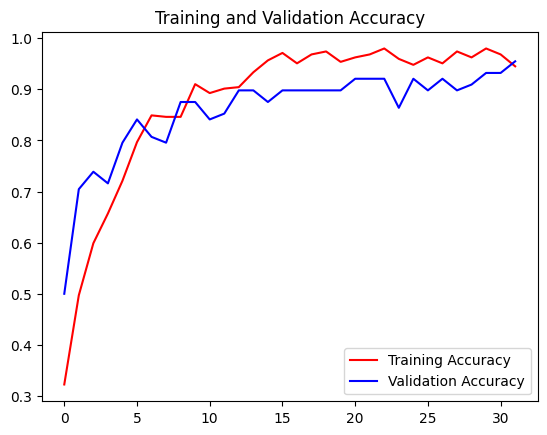

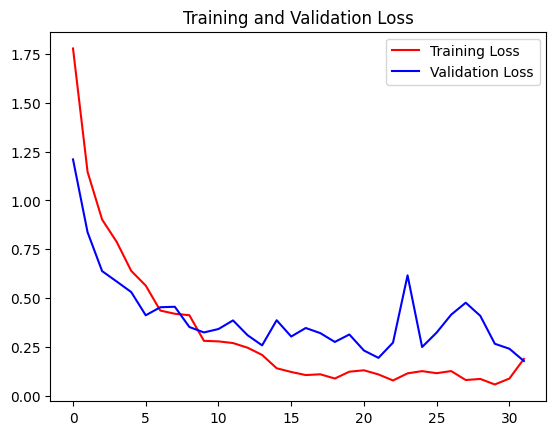

<Figure size 640x480 with 0 Axes>

In [552]:
acc = sequential_history.history['accuracy']
val_acc = sequential_history.history['val_accuracy']
loss = sequential_history.history['loss']
val_loss = sequential_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [553]:
sequential_model.save('model_sequentialrambutan.h5')

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import cv2
def predict(path):
    model = load_model('model_sequentialrambutan.h5')
    # Untriggered tf.function 
    @tf.function
    def predict_image(img):
        return model.predict(img)
    # Load and preprocess a new image
    img = image.load_img(path, target_size=(256, 256))
    img = image.img_to_array(img)
    img = img / 255.0  # Normalize pixel values (if necessary)
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    # Make predictions
    predictions = model.predict(img, verbose = 0)
    # Interpret the predictions
    predicted_class = np.argmax(predictions)
    # Map predicted class to class label (if you have class labels)
    label = ['matangbusuk', 'matangsegar', 'mentahbusuk', 'mentahsegar']
    predicted_class_label = label[predicted_class]
    # Print or use the prediction
    print("Kualitas Rambutan :", predicted_class_label)
    #Show predicted Image
    img_path = path  
    images = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title('Predicted Image')
    plt.show()

Kualitas Rambutan : mentahbusuk


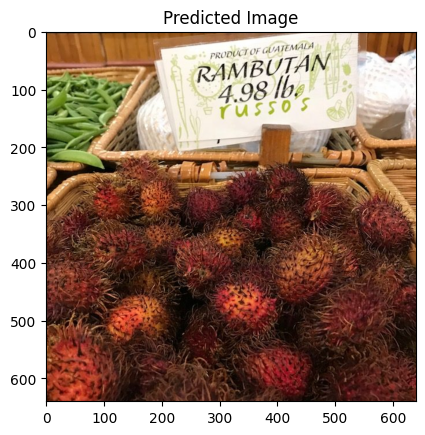

In [24]:
predict("Test/datatestrambutan/matangbusuk/t4.jpg")

2/2 [==============================] - 0s 42ms/step


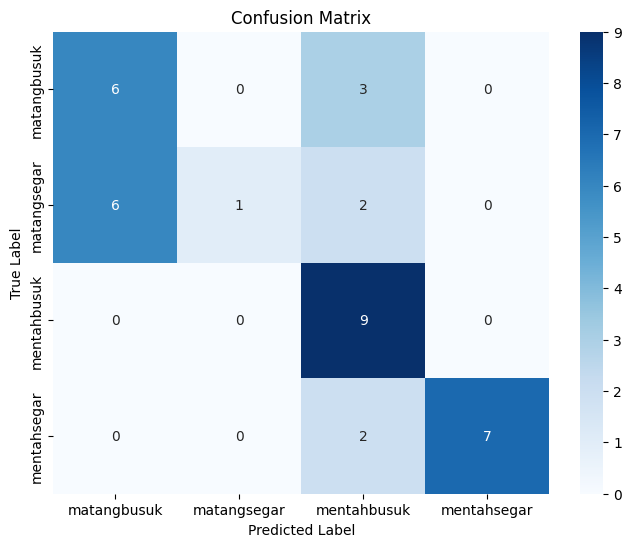


Classification Results :
              precision    recall  f1-score   support

 matangbusuk       0.50      0.67      0.57         9
 matangsegar       1.00      0.11      0.20         9
 mentahbusuk       0.56      1.00      0.72         9
 mentahsegar       1.00      0.78      0.88         9

    accuracy                           0.64        36
   macro avg       0.77      0.64      0.59        36
weighted avg       0.77      0.64      0.59        36



In [33]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Specify the test data folder path
test_data_dir = "Test/datatestrambutan"
class_names = sorted(os.listdir(test_data_dir))

# create a function to load and process images
def load_and_process_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    # Normalize to a range of 0-1
    img_array = img_array / 255.0
    return img_array
    
# Function to load test data and labels
def load_test_data(test_dir):
    data = []
    labels = []
    class_mapping = {class_name: i for i, class_name in enumerate(class_names)}  # Encoding kelas

    for class_name in class_names:
        class_path = os.path.join(test_dir, class_name)

        #Add folder existence check
        if not os.path.isdir(class_path):
            print(f"Warning: Folder {class_path} not found.")
            continue

        class_label = class_mapping[class_name]
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:
                img_array = load_and_process_image(image_path)
                data.append(img_array)
                labels.append(class_label)
            except Exception as e:
                print(f"Error loading image {image_path}: {str(e)}")

    return np.array(data), np.array(labels)

# Load model
model = keras.models.load_model('model_sequentialrambutan.h5')

# Load data uji
X_test, y_test = load_test_data(test_data_dir)

# Make predictions using the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(keras.utils.to_categorical(y_test), axis=1)

# Model evaluation
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Show Classification Report
print("\nClassification Results :")
print(classification_rep)

In [558]:
#DENSENET121 MODEL

In [308]:
from tensorflow.keras.applications import DenseNet121
base_densenet_model = DenseNet121(include_top=False,
                   input_shape=(256,256,3),
                   pooling = 'max',
                   weights='imagenet')
for layer in base_densenet_model.layers:
    layer.trainable = False

In [311]:
from tensorflow import keras
inputs = keras.Input(shape=(256,256,3))
x = base_densenet_model(inputs, training = False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(16, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(4, activation = 'softmax')(x)
densenet_model = keras.Model(inputs = inputs, outputs = outputs)
densenet_model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 flatten_28 (Flatten)        (None, 1024)              0         
                                                                 
 dense_56 (Dense)            (None, 16)                16400     
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_57 (Dense)            (None, 4)                 68        
                                                                 
Total params: 7053972 (26.91 MB)
Trainable params: 16468 (

In [235]:
from tensorflow.keras.optimizers import Adam
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= .98 and logs.get('accuracy') >= .98):
            self.model.stop_training = True
            print('\nAccuracy Complete')
callbacks = myCallbacks()
history_densenet = densenet_model.fit(train_generator, epochs=50,validation_data=validation_generator,verbose=1,
                    callbacks=[callbacks])

Epoch 1/50
11/11 [==============================] - 59s 5s/step - loss: 1.1623 - accuracy: 0.4709 - val_loss: 0.9909 - val_accuracy: 0.6591
Epoch 2/50
11/11 [==============================] - 52s 5s/step - loss: 0.7138 - accuracy: 0.7151 - val_loss: 0.6643 - val_accuracy: 0.7273
Epoch 3/50
11/11 [==============================] - 57s 5s/step - loss: 0.4826 - accuracy: 0.8169 - val_loss: 0.5599 - val_accuracy: 0.7727
Epoch 4/50
11/11 [==============================] - 63s 6s/step - loss: 0.4188 - accuracy: 0.8256 - val_loss: 0.3967 - val_accuracy: 0.8636
Epoch 5/50
11/11 [==============================] - 59s 5s/step - loss: 0.3328 - accuracy: 0.8866 - val_loss: 0.3703 - val_accuracy: 0.8864
Epoch 6/50
11/11 [==============================] - 59s 5s/step - loss: 0.2499 - accuracy: 0.9157 - val_loss: 0.2959 - val_accuracy: 0.8977
Epoch 7/50
11/11 [==============================] - 60s 6s/step - loss: 0.2534 - accuracy: 0.9099 - val_loss: 0.3095 - val_accuracy: 0.9091
Epoch 8/50
11/11 [==

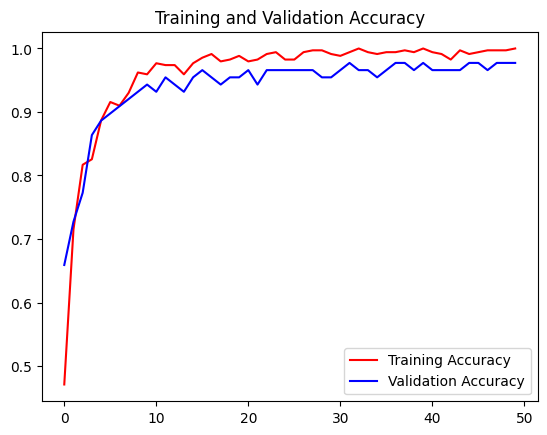

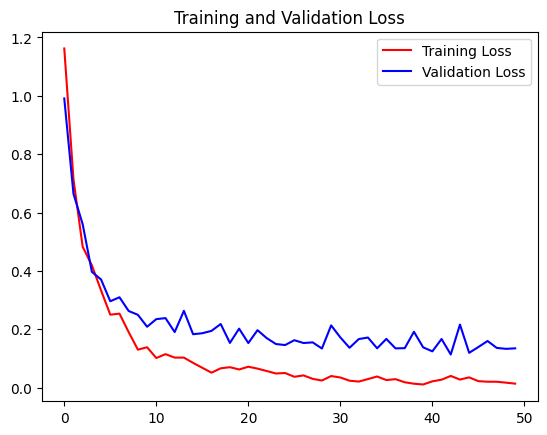

<Figure size 640x480 with 0 Axes>

In [302]:
acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']
loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import cv2
def predict_densenet(path):
    model = load_model('model_Resnet50rambutan.h5')#Model DenseNet121, salah simpan nama model
    # Untriggered tf.function 
    @tf.function
    def predict_image(img):
        return model.predict(img)
    # Load and preprocess a new image
    img = image.load_img(path, target_size=(256, 256))
    img = image.img_to_array(img)
    img = img / 255.0  # Normalize pixel values (if necessary)
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    # Make predictions
    predictions = model.predict(img, verbose = 0)
    # Interpret the predictions
    predicted_class = np.argmax(predictions)
    # Map predicted class to class label (if you have class labels)
    label = ['matangbusuk', 'matangsegar', 'mentahbusuk', 'mentahsegar']
    predicted_class_label = label[predicted_class]
    # Print or use the prediction
    print("Kualitas Rambutan :", predicted_class_label)
    #Show predicted Image
    img_path = path  
    images = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title('Predicted Image')
    plt.show()

Kualitas Rambutan : matangbusuk


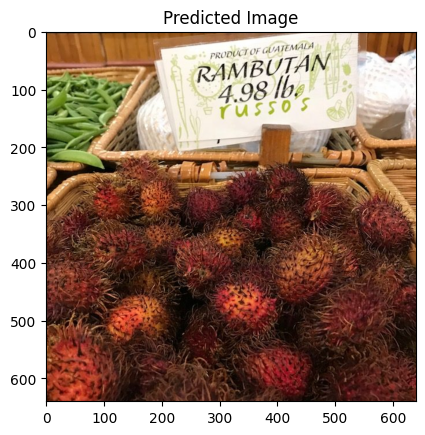

In [26]:
predict_densenet("Test/datatestrambutan/matangbusuk/t4.jpg")

2/2 [==============================] - 10s 797ms/step


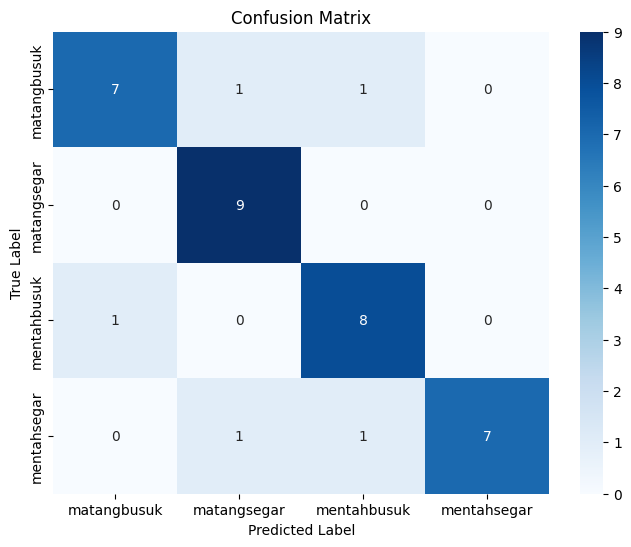


Classification Results :
              precision    recall  f1-score   support

 matangbusuk       0.88      0.78      0.82         9
 matangsegar       0.82      1.00      0.90         9
 mentahbusuk       0.80      0.89      0.84         9
 mentahsegar       1.00      0.78      0.88         9

    accuracy                           0.86        36
   macro avg       0.87      0.86      0.86        36
weighted avg       0.87      0.86      0.86        36



In [32]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Specify the test data folder path
test_data_dir = "Test/datatestrambutan"
class_names = sorted(os.listdir(test_data_dir))

# create a function to load and process images
def load_and_process_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    # Normalize to a range of 0-1
    img_array = img_array / 255.0
    return img_array
    
# Function to load test data and labels
def load_test_data(test_dir):
    data = []
    labels = []
    class_mapping = {class_name: i for i, class_name in enumerate(class_names)}  # Encoding kelas

    for class_name in class_names:
        class_path = os.path.join(test_dir, class_name)

        #Add folder existence check
        if not os.path.isdir(class_path):
            print(f"Warning: Folder {class_path} not found.")
            continue

        class_label = class_mapping[class_name]
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:
                img_array = load_and_process_image(image_path)
                data.append(img_array)
                labels.append(class_label)
            except Exception as e:
                print(f"Error loading image {image_path}: {str(e)}")

    return np.array(data), np.array(labels)

# Load model
model = keras.models.load_model('model_Resnet50rambutan.h5')

# Load data uji
X_test, y_test = load_test_data(test_data_dir)

# Make predictions using the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(keras.utils.to_categorical(y_test), axis=1)

# Model evaluation
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Show classification report
print("\nClassification Results :")
print(classification_rep)